Move current directory to project root

In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path

if 'project_root' not in dir():
    project_root = Path.cwd().parent
    
os.chdir(project_root)

Toy dataset

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from model_zoo.datasets.generated import Sphere
from model_zoo.datasets.utils import OmitLabels

dataset = Sphere('', 'test', manifold_dim=1, ambient_dim=2, mu=np.array([-3, -3]))
dataloader = DataLoader(OmitLabels(dataset), batch_size=50)

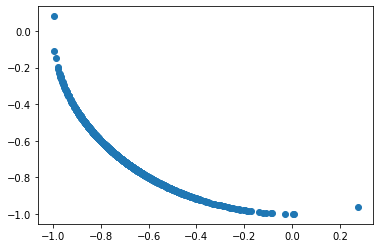

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(dataset.x[:, 0], dataset.x[:, 1])

Construct a flow consisting of one simple linear transformation

In [4]:
from torch import optim
from model_zoo.density_estimator.flow import NormalizingFlow

flow = NormalizingFlow(
    dim=2,
    transform=[{
        'class_path': 'nflows.transforms.lu.LULinear',
        'init_args': {
            'features': 2
        }
    }],
)

optimizer = optim.Adam(flow.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda step: 1
)

flow.optimizer = optimizer
flow.lr_scheduler = scheduler

Train the flow

/home/brendan/anaconda3/envs/ood/lib/python3.9/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2191.)
  outputs, _ = torch.triangular_solve(


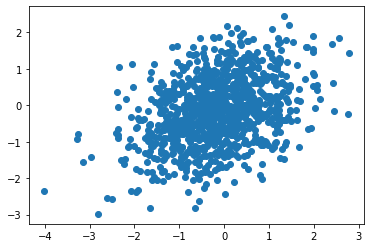

In [5]:
for epoch in range(10):
    for batch in dataloader:
        flow.train_batch(batch)
    
gen_sample = flow.sample(1000).detach()
plt.scatter(gen_sample[:, 0], gen_sample[:, 1])

Evaluate 

In [13]:
from ood.methods.linear_approximations.latent_statistics import EllipsoidCDFStatsCalculator
from ood.methods.linear_approximations.encoding_model import EncodingFlow


ellipsoid_calc = EllipsoidCDFStatsCalculator(flow, EncodingFlow)
ellipsoid_calc.sample(0.01, dataloader, 20)

flattening


IndexError: too many indices for tensor of dimension 4